In [847]:
import jax
import jax.numpy as jnp
import flax.linen as nn

from clu import metrics
from flax.training import train_state
from flax import struct

import optax

import matplotlib.pyplot as plt

from jaxtyping import Array, Float, PyTree

In [742]:
# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 3e-3
STEPS = 1000
PRINT_EVERY = 30
SEED = 2025

key = jax.random.PRNGKey(SEED)

In [1335]:
class CNNet(nn.Module):
    kernel_size: int

    @nn.compact
    def __call__(self, x):
        bs = x.shape[0]
        x = nn.Conv(
            features=10,
            kernel_size=self.kernel_size,
            padding=self.kernel_size//2,
            use_bias=False
        )(x).reshape(bs, -1)
        x = nn.tanh(x)
        x = nn.Dense(features=10)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=10)(x)
        x = nn.tanh(x)
        x = nn.Dense(features=1)(x)
        return x

class LNet(nn.Module):

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=10)(x.squeeze())
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x



In [1336]:
@struct.dataclass
class Metrics(metrics.Collection):
    accuracy: metrics.Accuracy
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

def create_train_state(module, rng, learning_rate):
    params = module.init(rng, jnp.ones((1,100,1)))['params']
    tx = optax.adam(learning_rate)

    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        tx=tx,
        metrics=Metrics.empty()
    )

@jax.jit
def train_step(state, X, Y):

    def loss_fn(params):
        Y_hat = state.apply_fn({'params':params}, X)
        loss = ((Y.squeeze() - Y_hat.squeeze())**2).mean()
        return loss

    loss = loss_fn(state.params)
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss


In [1367]:
key, sk1, sk2 = jax.random.split(key, 3)
sigma = 1

t = jnp.linspace(0,1,100)
Y = jax.random.uniform(sk1,shape=1000, minval=-1, maxval=1)*sigma
X = [jnp.sin(t * y) for y in Y]
X = jnp.stack(X)
X = jnp.expand_dims(X, -1)

# Corrupt
# Y += jax.random.normal(sk, shape=1000)*0





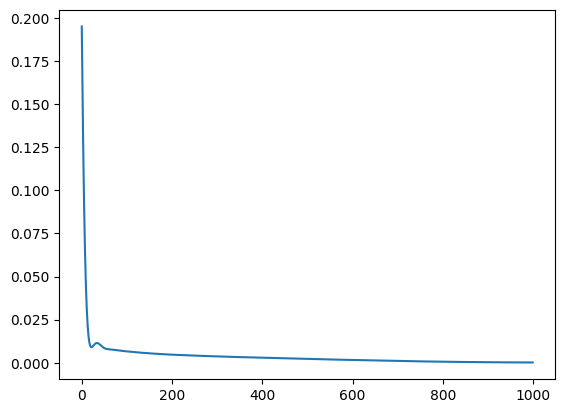

In [1379]:
net = CNNet(21)
# net = LNet()

key, sk1 = jax.random.split(key, 2)
state = create_train_state(net, sk1, 1e-4)
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
}

losses = []
epochs = 1000
for _ in range(epochs):
    # key, sk = jax.random.split(key, 2)
    # Y_alt = Y + jax.random.normal(sk, shape=1000)*0
    state, loss = train_step(state, X, Y)
    losses.append(loss)
    # state = compute_metrics(state=state, X=X, Y=Y)

plt.plot(losses)

In [1380]:
key, sk = jax.random.split(key, 2)

Y_test = jax.random.uniform(sk, minval=-10, maxval=10, shape=1000)
X_test = [jnp.sin(t * y) for y in Y_test]
X_test = jnp.stack(X_test)
X_test = jnp.expand_dims(X_test, -1)

Y_hat = state.apply_fn({'params':state.params}, X).squeeze()
Y_test_hat = state.apply_fn({'params':state.params}, X_test).squeeze()

Text(0, 0.5, 'Predicted frequency')

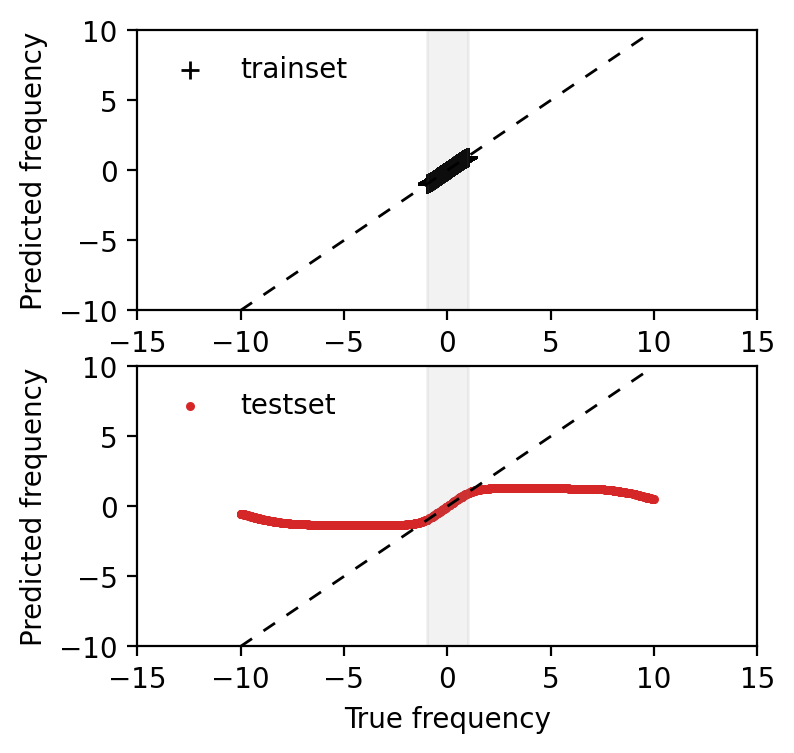

In [1381]:
fig, axs = plt.subplots(2,1,figsize=(4,4), dpi=200)

ax = axs[0]
ax.scatter(Y, Y_hat, label='trainset', c='black', s=40, marker='+', linewidths=1)
ax.legend(ncols=2, frameon=False)

line_xy = [-10, 10]
ax.plot(line_xy, line_xy, c='black', linestyle=(0,(5,5)), linewidth=1)
ax.fill_between([-sigma,sigma], [-10,-10],[10,10], alpha=0.1, color='gray')

ax.set_xlim(-15,15)
ax.set_ylim(-10,10)
ax.set_xlabel('True frequency')
ax.set_ylabel('Predicted frequency')

ax = axs[1]
ax.scatter(Y_test, Y_test_hat, label='testset', c='tab:red', s=5)
ax.legend(ncols=2, frameon=False)

line_xy = [-10, 10]
ax.plot(line_xy, line_xy, c='black', linestyle=(0,(5,5)), linewidth=1)
ax.fill_between([-sigma,sigma], [-10,-10],[10,10], alpha=0.1, color='gray')

ax.set_xlim(-15,15)
ax.set_ylim(-10,10)


ax.set_xlabel('True frequency')
ax.set_ylabel('Predicted frequency')

In [1382]:
k[0].shape

(10,)

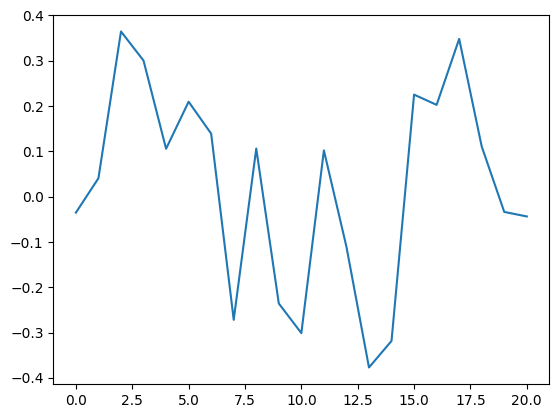

In [1390]:
k = state.params['Conv_0']['kernel'].squeeze()

plt.plot(k.T[6])

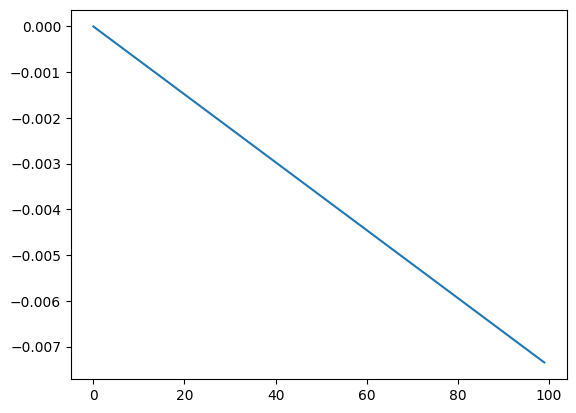

In [1326]:
plt.plot(jnp.sin(t * Y.mean()))